## Get the [Data](https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images/data)

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
!pip install kaggle

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/kaggle"

In [4]:
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images

100% 1.76G/1.76G [01:31<00:00, 22.3MB/s]
100% 1.76G/1.76G [01:31<00:00, 20.7MB/s]


In [5]:
import zipfile

# unzip the downloaded file
zip_ref = zipfile.ZipFile("/content/lung-and-colon-cancer-histopathological-images.zip")
zip_ref.extractall()
zip_ref.close()

In [6]:
# inspect the data
!ls /content/lung_colon_image_set
lung_colon_directory = "/content/lung_colon_image_set/"

colon_image_sets  lung_image_sets


### Move the subclasses folder from colon and lung folders

In [7]:
import os
import shutil

colon_dir = "/content/lung_colon_image_set/colon_image_sets/"
lung_dir = "/content/lung_colon_image_set/lung_image_sets/"

subfolders_colon_dir = [folder for folder in os.listdir(colon_dir) if os.path.isdir(os.path.join(colon_dir, folder))]
subfolders_lung_dir = [folder for folder in os.listdir(lung_dir) if os.path.isdir(os.path.join(lung_dir, folder))]

In [8]:
# move sub-class colon
for subfolder in subfolders_colon_dir:
  shutil.move(colon_dir + subfolder, lung_colon_directory)
os.removedirs(colon_dir)

In [9]:
# move sub-class lung
for subfolder in subfolders_lung_dir:
  shutil.move(lung_dir + subfolder, lung_colon_directory)
os.removedirs(lung_dir)

In [10]:
!ls /content/lung_colon_image_set

colon_aca  colon_n  lung_aca  lung_n  lung_scc


### Get class names

In [11]:
import pathlib
import numpy as np

data_dir = pathlib.Path(lung_colon_directory)
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_names)

['colon_aca' 'colon_n' 'lung_aca' 'lung_n' 'lung_scc']


## Visualize Image

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # setup the target directory
  target_folder = target_dir + "/" + target_class

  # get a random image path
  random_image = random.sample(os.listdir(target_folder), 1) # get 1
  print(random_image)

  # read the image and plot it
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")

  print(f"Image Shape : {img.shape}")
  return img

['lungn385.jpeg']
Image Shape : (768, 768, 3)


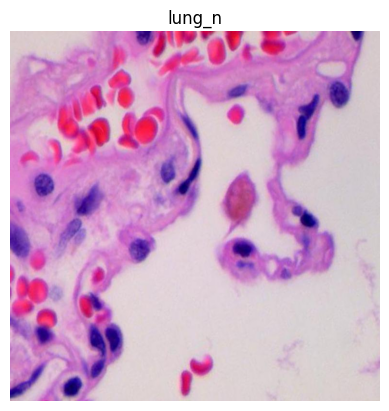

In [13]:
# visualize
import random
img = view_random_image(target_dir = lung_colon_directory,
                        target_class = random.choice(class_names))

## Preprocess the data

In [57]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1/255.,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split = 0.2) # set validation split

# load data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(lung_colon_directory,
                                               target_size = (224, 224),
                                               batch_size = 64,
                                               class_mode = "categorical",
                                               subset = "training") # set as training data

test_data = train_datagen.flow_from_directory(lung_colon_directory,
                                              target_size = (224, 224),
                                              batch_size = 64,
                                              class_mode = "categorical",
                                              shuffle = False,
                                              subset = "validation") # set as validation data

Found 20000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


## Create a Model

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

# create a model
model_1 = Sequential([
    Conv2D(10, 3, input_shape = (224, 224, 3), activation = "relu"),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation = "relu"),
    Conv2D(10, 3, activation = "relu"),
    MaxPool2D(),
    Flatten(),
    Dense(5, activation = "softmax")
])

# compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [60]:
# fit the model
history_1 = model_1.fit(train_data,
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = test_data,
                        validation_steps = (0.2 * len(test_data)))

Epoch 1/5
313/313 [==============================] - 341s 1s/step - loss: 0.6912 - accuracy: 0.6864 - val_loss: 0.6767 - val_accuracy: 0.7061
Epoch 2/5
313/313 [==============================] - 333s 1s/step - loss: 0.3370 - accuracy: 0.8670 - val_loss: 0.1831 - val_accuracy: 0.9258
Epoch 3/5
313/313 [==============================] - 336s 1s/step - loss: 0.2661 - accuracy: 0.8970 - val_loss: 0.1881 - val_accuracy: 0.9219
Epoch 4/5
313/313 [==============================] - 338s 1s/step - loss: 0.2417 - accuracy: 0.9076 - val_loss: 0.1798 - val_accuracy: 0.9326
Epoch 5/5
313/313 [==============================] - 345s 1s/step - loss: 0.2114 - accuracy: 0.9233 - val_loss: 0.0862 - val_accuracy: 0.9785


## Evaluate the model

In [61]:
model_1.evaluate(test_data)

79/79 [==============================] - 79s 1s/step - loss: 0.2021 - accuracy: 0.9222


[0.20205819606781006, 0.9222000241279602]

## Plot Validation

In [62]:
def plot_loss_curves(history):
  """
  Returns separates loss curves for training and validation metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"])) # how many epochs

  # plot loss
  plt.plot(epochs, loss, label = "Training_loss")
  plt.plot(epochs, val_loss, label = "Val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # plot accuracy
  plt.figure() # create a new plot box
  plt.plot(epochs, accuracy, label = "Training_accuracy")
  plt.plot(epochs, val_accuracy, label = "Val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

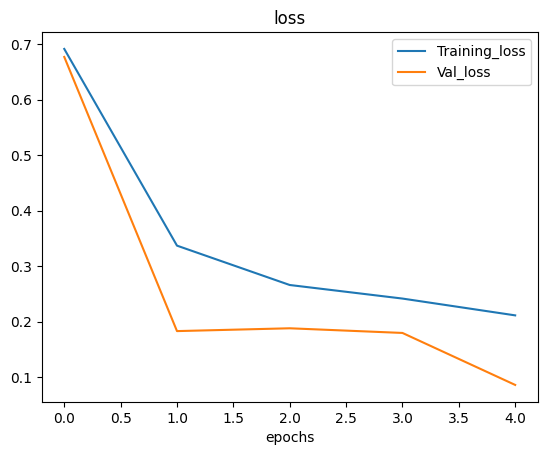

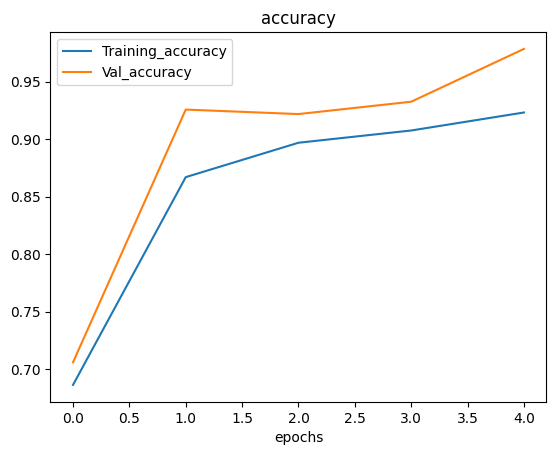

In [63]:
# plot the curves
plot_loss_curves(history_1)

## Make Prediction with custom images

In [64]:
class_names

array(['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'],
      dtype='<U9')

In [65]:
# function to import and resize the image like we used in our model
def load_and_prep_image(filename, img_shape = 224):
  """
  Reads an image from filename, turn it into a tensor and reshape it
  """
  # read in the image
  img = tf.io.read_file(filename)
  # decode the image into a tensor
  img = tf.image.decode_image(img)
  # resize the image
  img = tf.image.resize(img, size = [img_shape, img_shape])
  # rescale the image (get all values between 0 and 1)
  img = img/255
  return img

In [66]:
def pred_and_plot(model, filename, class_names = class_names):
  """
  import an image, make a prediction, and plot the image with the predicted class as the title
  """
  # import the target image and preprocess it
  img = load_and_prep_image(filename)

  # make a prediction
  pred = model.predict(tf.expand_dims(img, axis = 0))
  print(pred)

  # get the predicted class
  # 1. if multi class
  if (len(pred[0]) > 1):
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred))]

  # plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

1/1 [==============================] - 0s 67ms/step
[[8.4074962e-01 1.5871437e-01 1.4328381e-05 5.2170275e-04 5.0701302e-14]]


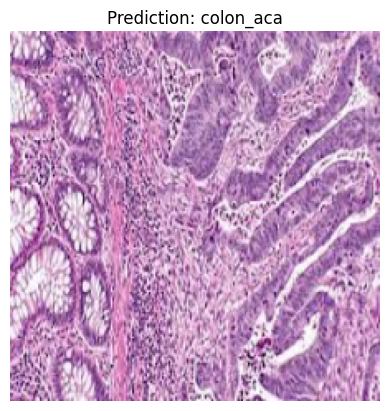

In [67]:
# make single prediction
pred_and_plot(model = model_1, filename = "/content/test_Colon adenocarcinoma.jpg", class_names = class_names)

## Confusion Matrix

In [69]:
class_names

array(['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'],
      dtype='<U9')

In [70]:
# convert all the prediction probabilities into integers
preds = model_1.predict(test_data)
y_pred = np.argmax(preds , axis = 1)

79/79 [==============================] - 83s 1s/step


In [71]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_true = test_data.labels,
                 y_pred = y_pred)

array([[982,  12,   2,   4,   0],
       [124, 875,   1,   0,   0],
       [  9,   0, 868,  11, 112],
       [  0,   0,   6, 994,   0],
       [  1,   0, 101,   0, 898]])

In [72]:
# create cofusion matrix
import itertools
from sklearn.metrics import confusion_matrix

figsize = (10, 10)

def make_confusion_matrix(y_true, y_pred, classes = None, figsize = (10, 10), text_size = 15):
  # create the confusion matrix
  cm = confusion_matrix(y_true,  y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis = 1)[:, np.newaxis] # normalize confusion matrix
  n_classes = cm.shape[0]

  # prettify it
  fig, ax = plt.subplots(figsize = figsize)
  # create a matrix plot
  cax = ax.matshow(cm, cmap = plt.cm.Blues)
  fig.colorbar(cax)

  # create classes
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # label the axes
  ax.set(title = "Confusion Matrix",
        xlabel = "Predicted Label",
        ylabel = "True Label",
        xticks = np.arange(n_classes),
        yticks = np.arange(n_classes),
        xticklabels = labels,
        yticklabels = labels)

  # set x-axis labels to bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # adjust the label size
  ax.yaxis.label.set_size(text_size)
  ax.xaxis.label.set_size(text_size)
  ax.title.set_size(text_size)

  # set threshold for different colors
  threshold = (cm.max() + cm.min()) / 2

  # plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
            horizontalalignment = "center",
            color = "white" if cm[i, j] > threshold else "black",
            size = text_size)

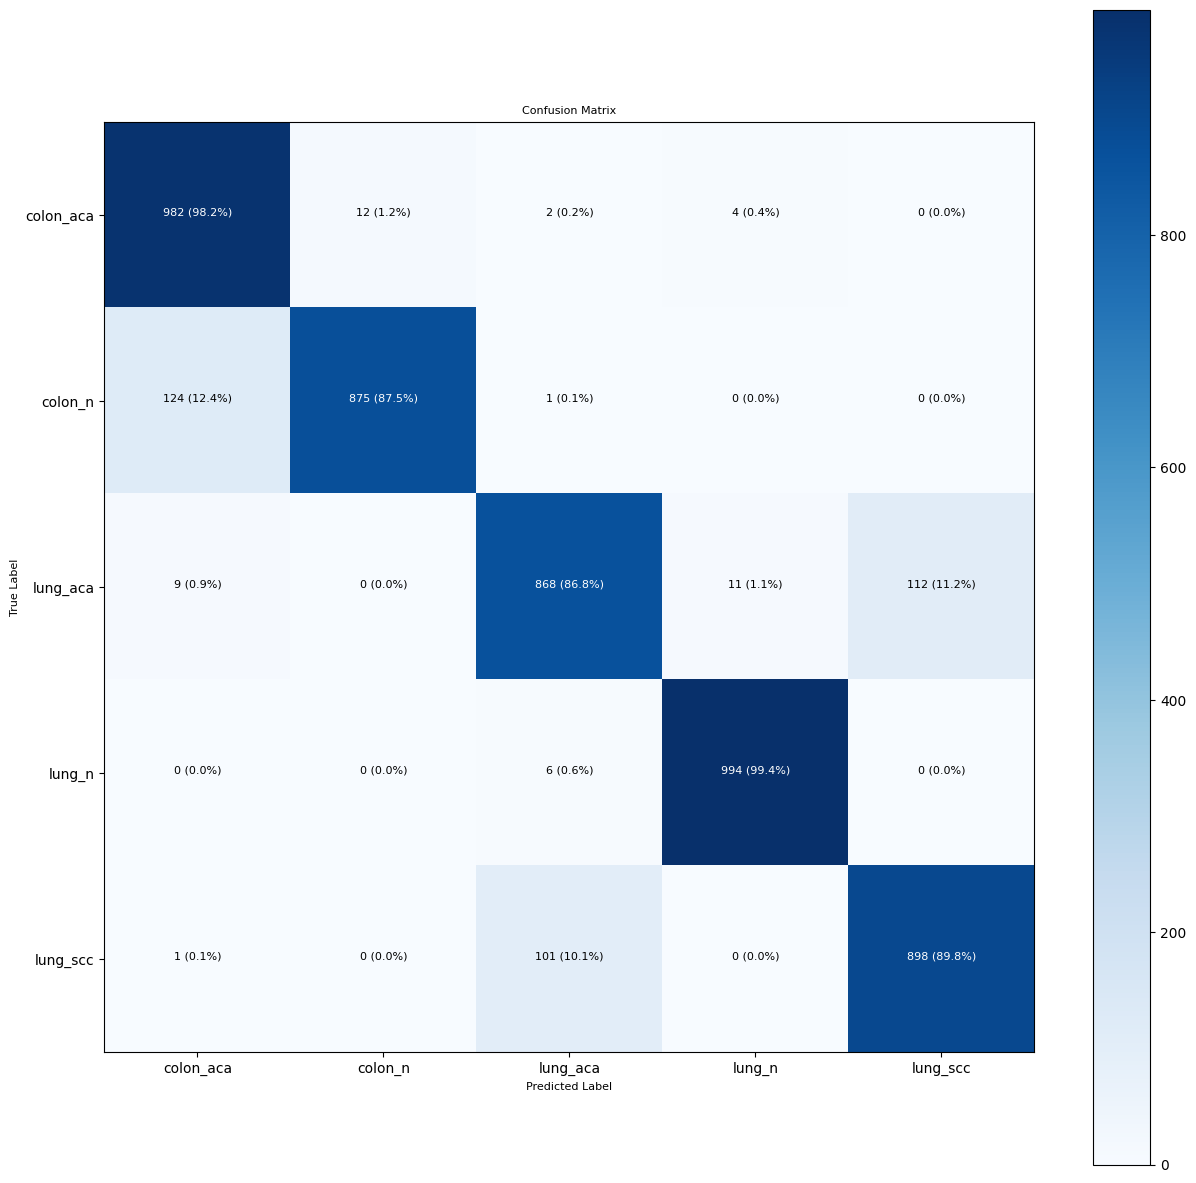

In [74]:
make_confusion_matrix(y_true = test_data.labels, y_pred = y_pred, classes = list(class_names), figsize = (15, 15), text_size = 8)